In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score

In [46]:
# 加载数据
file_path = "E:\竞赛\服创赛-A08\data\欺诈手段特征集.xlsx"
data = pd.read_excel(file_path)

# 展示数据的前几行以及基本信息
data.head(), data.info(), data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   就诊次数_SUM     16000 non-null  int64  
 1   药品在总金额中的占比   16000 non-null  float64
 2   个人支付的药品占比    16000 non-null  float64
 3   检查总费用在总金额占比  16000 non-null  float64
 4   治疗费用在总金额占比   16000 non-null  float64
 5   就诊的月数        16000 non-null  int64  
 6   月就诊天数_MAX    16000 non-null  int64  
 7   月就诊天数_AVG    16000 non-null  float64
 8   月就诊医院数_MAX   16000 non-null  int64  
 9   月就诊医院数_AVG   16000 non-null  float64
 10  RES          16000 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 1.3 MB


(   就诊次数_SUM  药品在总金额中的占比  个人支付的药品占比  检查总费用在总金额占比  治疗费用在总金额占比  就诊的月数  月就诊天数_MAX  \
 0        34    0.939194   0.004262     0.050817    0.007434      6          7   
 1        15    0.955626   0.002982     0.030815    0.013398      6          4   
 2        45    0.783610   0.000332     0.000000    0.195087      6          8   
 3        23    0.458649   0.000184     0.000000    0.541351      6          6   
 4        26    0.983726   0.000316     0.000000    0.016274      6          5   
 
    月就诊天数_AVG  月就诊医院数_MAX  月就诊医院数_AVG  RES  
 0   5.666667           3    2.166667    0  
 1   2.500000           2    1.333333    0  
 2   6.166667           3    2.166667    0  
 3   3.666667           2    1.833333    0  
 4   4.333333           1    1.000000    0  ,
 None,
            就诊次数_SUM    药品在总金额中的占比     个人支付的药品占比   检查总费用在总金额占比    治疗费用在总金额占比  \
 count  16000.000000  16000.000000  16000.000000  16000.000000  16000.000000   
 mean      36.818438      0.854763      0.005500      0.039006      

In [47]:
# 删除高度相关的特征（>0.9）--可选
data = data.drop(columns=['月就诊天数_MAX', '月就诊天数_AVG', '月就诊医院数_MAX'])

In [48]:
# 分离特征和目标变量
X = data.drop('RES', axis=1)
y = data['RES']

# 分离类别
data_majority = data[data.RES == 0]
data_minority = data[data.RES == 1]

In [49]:
# 定义一个函数来执行带有不同欠采样比例的交叉验证
def evaluate_downsampling_ratios(X, y, ratios):
    results = {}
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    for ratio in ratios:
        print(f"\n欠采样比例: {ratio}:1")
        
        for train_index, test_index in skf.split(X, y):
            # 分割数据
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # 分离多数和少数类
            X_train_majority = X_train[y_train == 0]
            X_train_minority = X_train[y_train == 1]

            # 执行欠采样
            majority_sample_size = int(len(X_train_minority) * ratio)
            X_train_majority_downsampled = resample(X_train_majority, 
                                                    replace=False,
                                                    n_samples=majority_sample_size,
                                                    random_state=123)
            y_train_majority_downsampled = y_train.loc[X_train_majority_downsampled.index]

            # 合并数据
            X_train_downsampled = pd.concat([X_train_majority_downsampled, X_train_minority])
            y_train_downsampled = pd.concat([y_train_majority_downsampled, y_train[y_train == 1]])

            # 创建并训练模型
            RF_1 = RandomForestClassifier(n_estimators=100, random_state=123, n_jobs=-1)
            RF_1.fit(X_train_downsampled, y_train_downsampled)

            # 预测
            y_pred = RF_1.predict(X_test)

            # 输出分类报告
            print(classification_report(y_test, y_pred))

# 欠采样比例
ratios = [1, 2, 3, 4, 5]

# 执行评估
evaluate_downsampling_ratios(X, y, ratios)


欠采样比例: 1:1
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      3042
           1       0.14      0.69      0.23       158

    accuracy                           0.77      3200
   macro avg       0.56      0.73      0.55      3200
weighted avg       0.94      0.77      0.83      3200

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      3042
           1       0.13      0.73      0.22       158

    accuracy                           0.74      3200
   macro avg       0.55      0.73      0.53      3200
weighted avg       0.94      0.74      0.81      3200

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      3041
           1       0.14      0.71      0.23       159

    accuracy                           0.77      3200
   macro avg       0.56      0.74      0.55      3200
weighted avg       0.94      0.77      0.83      3200

       

In [50]:
# 定义一个额外的函数，用于单独训练和返回比例为4的模型
def get_specific_ratio_model(X, y, specific_ratio):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    final_model = None

    for train_index, test_index in skf.split(X, y):
        # 分割数据
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # 分离多数和少数类
        X_train_majority = X_train[y_train == 0]
        X_train_minority = X_train[y_train == 1]

        # 执行欠采样
        majority_sample_size = int(len(X_train_minority) * specific_ratio)
        X_train_majority_downsampled = resample(X_train_majority, 
                                                replace=False,
                                                n_samples=majority_sample_size,
                                                random_state=123)
        y_train_majority_downsampled = y_train.loc[X_train_majority_downsampled.index]

        # 合并数据
        X_train_downsampled = pd.concat([X_train_majority_downsampled, X_train_minority])
        y_train_downsampled = pd.concat([y_train_majority_downsampled, y_train[y_train == 1]])

        # 创建并训练模型
        RF_1 = RandomForestClassifier(n_estimators=100, random_state=123, n_jobs=-1)
        RF_1.fit(X_train_downsampled, y_train_downsampled)

        # 更新最后一个模型
        final_model = RF_1

    return final_model

In [51]:
# 获取比例为n:1的模型(提高比例会略微提高AUC，但不显著)
specific_ratio = 6
RF_1 = get_specific_ratio_model(X, y, specific_ratio)

# 输出比例为4的模型
RF_1

RandomForestClassifier(n_jobs=-1, random_state=123)

In [52]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# 设置阈值为0.6
threshold = 0.6

# 以概率形式获取预测结果
y_probs = RF_1.predict_proba(X_test)[:, 1] # 获取正类的概率

# 应用阈值
y_pred_thresh = np.where(y_probs > threshold, 1, 0)

# 生成分类报告
classification_report_06 = classification_report(y_test, y_pred_thresh)

print(classification_report_06)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4572
           1       0.84      0.82      0.83       228

    accuracy                           0.98      4800
   macro avg       0.92      0.91      0.91      4800
weighted avg       0.98      0.98      0.98      4800



In [53]:
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_proba = RF_1.predict_proba(X_test)[:, 1]

# 计算AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")

AUC: 0.9669935035532838


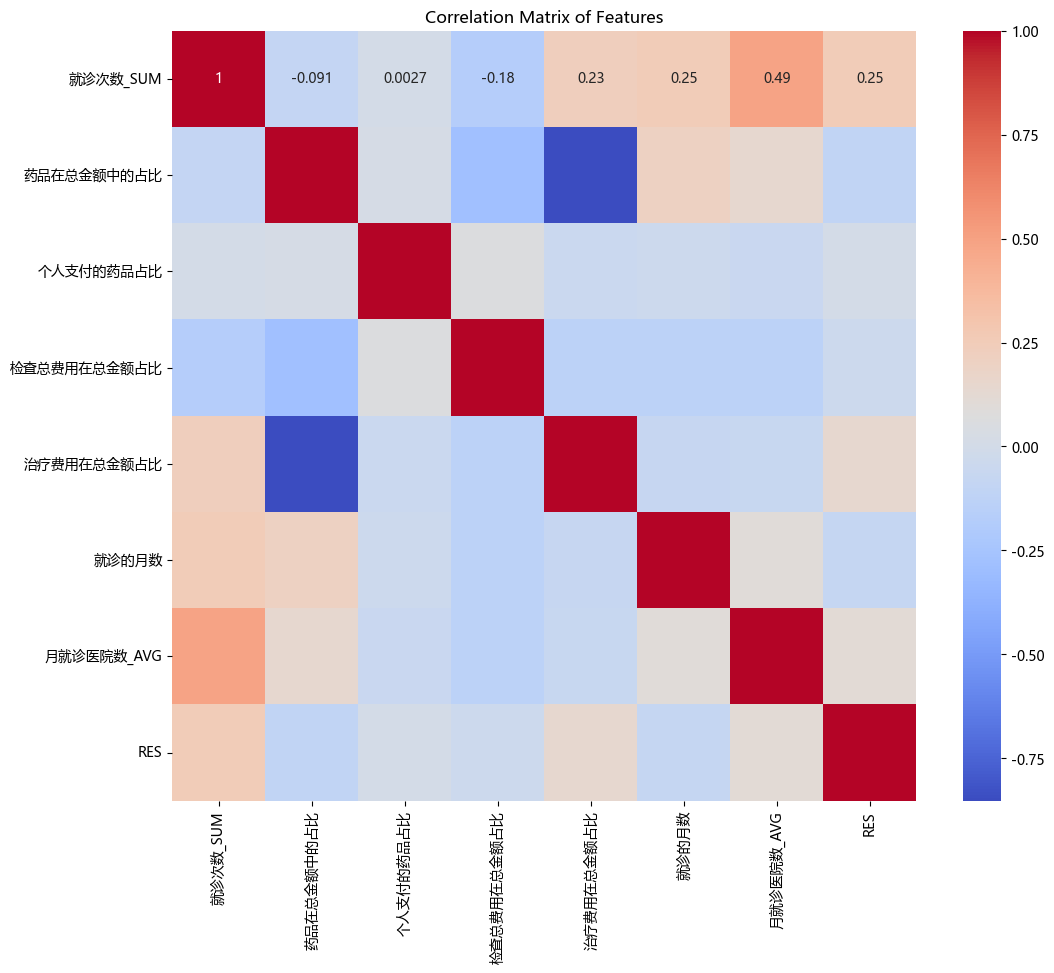

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns",100)
pd.set_option('display.max_rows',100)

from pylab import mpl 
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 为了显示负号正常


correlation_matrix = data.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

In [55]:
high_corr_pairs = []

for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        if (correlation_matrix.loc[row, col] > 0.9) and (col != row):
            # Check if the pair is already added
            if not {(row, col), (col, row)}.intersection(set(high_corr_pairs)):
                high_corr_pairs.append((row, col))

high_corr_pairs

[]

In [56]:
# 获取特征重要性
feature_importances = RF_1.feature_importances_

# 排序特征重要性
sorted_idx = np.argsort(feature_importances)[::-1]

# 取出前二十个重要特征
feature_importances = np.array(X.columns)[sorted_idx][:10]

feature_importances

array(['就诊次数_SUM', '药品在总金额中的占比', '治疗费用在总金额占比', '个人支付的药品占比', '检查总费用在总金额占比',
       '月就诊医院数_AVG', '就诊的月数'], dtype=object)